In [1]:
%matplotlib inline
import torch  as t
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable as V
from ipywidgets import interact, fixed
from IPython.display import clear_output
import gc

def affine_transform(input,mat):
    coor=coordinate_one()
    xyzprime=t.tensordot(coor,t.t(mat),dims=1)
    return trilinear(input,xyzprime)

def coordinate(shape):
    coor=np.asarray(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z)))
    coor=np.rollaxis(coor,0,2)
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,4)
    return V(t.tensor(coor),True)

def coordinate_one():
    coor=np.asarray(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z)))
    coor=np.rollaxis(coor,0,2)
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,4)
    onesMatrix = np.ones((X,Y,Z,1))
    coorMatrix = np.concatenate((coor, onesMatrix), axis=3)
    return V(t.tensor(coorMatrix),True)
    
def trilinear(img,xyzprime):
    xp=xyzprime[:,:,:,0]
    yp=xyzprime[:,:,:,1]
    zp=xyzprime[:,:,:,2]
    LUX=t.floor(xp).int()
    LUY=t.floor(yp).int()
    LUZ=t.floor(zp).int()
    LUX=t.where(LUX>X-2,t.tensor(X-2),LUX.long())
    LUX=t.where(LUX<1,t.tensor(1),LUX)
    LUY=t.where(LUY>Y-2,t.tensor(Y-2),LUY.long())
    LUY=t.where(LUY<1,t.tensor(1),LUY)
    LUZ=t.where(LUZ>Z-2,t.tensor(Z-2),LUZ.long())
    LUZ=t.where(LUZ<1,t.tensor(1),LUZ)
    xd,yd,zd=yp-LUY.double(),xp-LUX.double(),zp-LUZ.double()
    k000,k001,k010,k011=img[LUX,LUY,LUZ],img[LUX,LUY,LUZ+1],img[LUX,LUY+1,LUZ],img[LUX,LUY+1,LUZ+1]
    k100,k101,k110,k111=img[LUX+1,LUY,LUZ],img[LUX+1,LUY,LUZ+1],img[LUX+1,LUY+1,LUZ],img[LUX+1,LUY+1,LUZ+1]
    i1=k000*(1-zd)+k001*zd
    i2=k010*(1-zd)+k011*zd
    j1=k100*(1-zd)+k101*zd
    j2=k110*(1-zd)+k111*zd
    w1=i1*(1-yd)+i2*yd
    w2=j1*(1-yd)+j2*yd
    res=w1*(1-xd)+w2*xd
    del w1,w2,i1,i2,j1,j2,k000,k001,k010,k011,k100,k101,k110,k111,xd,yd,zd,LUX,LUY,LUZ,xp,yp,zp
    return res
    

def imshow(img, mov, tmp):
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("moving")
    
    plt.subplot(1,3,2)
    plt.imshow(mov)
    plt.title("after transformation")
    
    plt.subplot(1,3,3)
    plt.imshow(tmp)
    plt.title("template")
    plt.show()

    
def display_images(image_z, moving, transformed, template):
    plt.subplots(1,3,figsize=(10,8))
    
    plt.subplot(1,3,1)
    plt.imshow(moving[image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(transformed[image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('transformed image')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(template[image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('template image')
    plt.axis('off')
    
    plt.show()
    
def interact_display(range,mov,transformed,template):
    interact(display_images, image_z=(0,mov.shape[0]-1,10),
         moving = fixed(mov.detach().numpy()), 
         transformed=fixed(tmplt.detach().numpy()), 
         template=fixed(template.detach().numpy()))

In [2]:
all=np.load("MRI_3D/OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_rep1.npz")
mov=all["moving"]
mov=V(t.tensor(mov).double(),True)
X,Y,Z=mov.shape
# template=all["fixed"]
# template=V(t.tensor(template).double(),True)
transformMatrix=V(t.tensor(np.array([[1.1,0,0,0],
                                     [0,1.1,0,0],
                                     [0,0,1.1,0],
                                     [0,0,0,1]])).double(), True)
template=affine_transform(mov,transformMatrix)


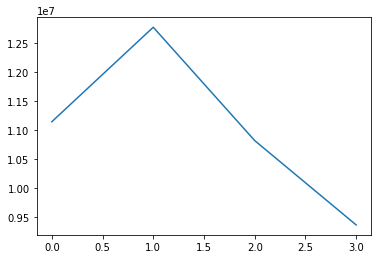

In [3]:
mat=V(t.tensor(np.array([[1,0,0,0],
                         [0,1,0,0],
                         [0,0,1,0],
                         [0,0,0,1]])).double(), True)
step=1e-9
iter=4
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=(template-tmplt)/255
    loss=t.sum(err**2)   
    loss.backward(retain_graph=True)
    losses.append(loss)
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
    gc.collect()
plt.plot(np.arange(iter), losses)

In [4]:
mat=V(t.tensor(np.array([[1,0,0,0],
                         [0,1,0,0],
                         [0,0,1,0],
                         [0,0,0,1]])).double(), True)
step=1e-5
iter=1
losses=[]
tmplt=affine_transform(mov,mat)
err=(template-tmplt)/255
loss=t.sum(err**2)   
loss.backward(retain_graph=True)
with t.no_grad():
    mat[:2,:2]-=step*mat.grad[:2,:2]
    mat[:2,2]-=step*mat.grad[:2,2]
    print(mat.grad)
    mat.grad.zero_()

tensor([[-6.7394e+07, -1.1367e+08, -9.5980e+07, -9.2191e+05],
        [-7.7848e+07, -8.2859e+07, -8.5879e+07, -8.1785e+05],
        [-5.2225e+07, -7.4717e+07, -8.7078e+07, -7.1281e+05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
       dtype=torch.float64)
